In [1]:
import torch
from utils import (
    load_config,
    load_model,
    create_metadata_tensor,
    load_slices,
    transform_to_hu,
    window,
    zoom_resize,
    normalise_slices,
    create_channels,
    calculate_optimal_slice,
    extract_optimal_range,
)
import matplotlib.pyplot as plt
from pathlib import Path
import SimpleITK as sitk
import numpy as np

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/workspaces/CTB_Osteoporosis_Screening/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### Identifying the slice above the lateral ventricles

In [ ]:
dir_path = "./data/masks/"
mask = sitk.ReadImage(dir_path)
mask_array = sitk.GetArrayFromImage(mask)
optimal_slice_idx = calculate_optimal_slice(mask_array)

### Making a prediction

In [3]:
# Load config
config = load_config("./model/config.json")
# Load the model
model = load_model(config, "./model/model.pt", device)

In [4]:
# Define age and sex for the model
age = 65  # Example age
sex = "female"  # Example sex
# Get normalization statistics for age
age_norm_stats = config["norm_stats"]["age"]
# Create metadata tensor
metadata = create_metadata_tensor(
    age, sex, age_norm_stats["mean"], age_norm_stats["std"], device
)
print(f"Metadata tensor: {metadata}")

Metadata tensor: tensor([-0.3066,  0.0000])


In [6]:
# Load slices
data_dir = "./data/scans/"
slices = load_slices(data_dir)
# Extract the optimal slice range
extracted_slices = extract_optimal_range(slices, optimal_slice_idx)

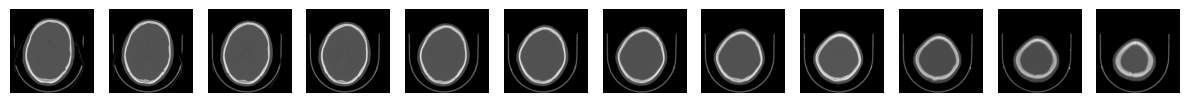

In [7]:
# Convert to Hounsfield Units (HU)
slices_hu = transform_to_hu(extracted_slices)
# Window the slices for display, input to model is not windowed
windowed_slices = window(slices_hu, window_center=600, window_width=2800)
# Visualise the slices
plt.figure(figsize=(12, 6))
for i, slice_ in enumerate(windowed_slices):
    plt.subplot(1, len(windowed_slices), i + 1)
    plt.imshow(slice_, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
# Stack the slices into a tensor
slices_tensor = torch.tensor(np.stack(slices_hu, axis=0), dtype=torch.float32).to(device)
# Resize the slices to the model's input size, as some images are not 512x512
slices_tensor = zoom_resize(slices_tensor, config["input_size"])
# Normalise the slices
image_norm_stats = config["norm_stats"]["image"]
slices_tensor = normalise_slices(
    slices_tensor, image_norm_stats["mean"], image_norm_stats["std"]
)
# Create overlapping channels
slices_tensor = create_channels(slices_tensor)

In [9]:
print(slices_tensor.shape)  # Should be (num_slices, 3, H, W)

torch.Size([10, 3, 512, 512])


In [10]:
# Define classes
if config["osteo_screen"]:
    classes = ["Normal/Osteopenia", "Osteoporosis"]
else:
    classes = ["Normal", "Osteopenia/Osteoporosis"]

In [11]:
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    # Add batch dimension to the tensors
    batched_metadata = metadata.unsqueeze(0).repeat(slices_tensor.shape[0], 1)
    # Forward pass
    outputs = model(slices_tensor, additional_data=batched_metadata)
    # Average the outputs across slices
    outputs = outputs.mean(dim=0, keepdim=True)
    # If the model outputs is a single output value, then we can convert it to two classes
    probs = torch.tensor(
        [1 - outputs, outputs]
    )  # Convert single output to two classes
    # Get the predicted class index
    predicted_idx = probs.argmax(dim=0).item()


print(f"Classes: [{', '.join(classes)}]")
print(f"Probabilities: [{', '.join(f'{p:.4%}' for p in probs)}]")
print(f"Predicted class: {classes[predicted_idx]} ({probs[predicted_idx]:.4%})")

Classes: [Normal, Osteopenia/Osteoporosis]
Probabilities: [95.4233%, 4.5767%]
Predicted class: Normal (95.4233%)
